In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import folium
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from folium import plugins
from folium.plugins import HeatMap
from IPython.display import display

from collections import Counter
from imblearn.over_sampling import SMOTE

# Preprocessing

### Load tweets from csv file

In [200]:
df = pd.read_csv("agaton_leyte.csv", encoding='latin-1')

### Extract latitude and longitude from the coordinates column.

In [201]:
df['coordinates'] = df['coordinates'].str.replace("{'longitude':", "",regex=True)
df['coordinates'] = df['coordinates'].str.replace(", 'latitude':", "")
df['coordinates'] = df['coordinates'].str.replace("}", "", regex=True)
df['Longitude'] = df['coordinates'].str.split(' ', expand = True)[1]
df['Latitude'] = df['coordinates'].str.split(' ', expand = True)[2]

### Counts tweets in each rating

In [202]:
df['rating'].value_counts()

0    59
1    21
2    20
Name: rating, dtype: int64

### Split data into training data and testing data

In [203]:
X = df['content']
Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.50)

### Instantiate vectorizer and fit on the training data

In [204]:
# instantiate countfvectorizer
vect = CountVectorizer(analyzer = "word", ngram_range=(1, 2))

# fit on the training data, transform training and test data
train_data = vect.fit_transform(X_train)
test_data = vect.transform(X_test)
train_data = train_data.toarray()

print(train_data.shape)
print(test_data.shape)

(50, 1531)
(50, 1531)


### Create separate training data that uses SMOTE technique

In [205]:
counter = Counter(Y_train)
print('Before SMOTE:', counter)
strategy = {2:13}
smt = SMOTE(sampling_strategy=strategy)
train_data_sm, Y_train_sm = smt.fit_resample(train_data, Y_train)
counter2 = Counter(Y_train_sm)
print('After SMOTE:', counter2)

Before SMOTE: Counter({0: 29, 1: 13, 2: 8})
After SMOTE: Counter({0: 29, 1: 13, 2: 13})


# Comparing Models

### Using logistic regression model,

In [206]:
# Logistic Regression model
lr = LogisticRegression()

lr.fit(train_data, Y_train)

lr.fit(train_data, Y_train)
print("Accuracy score (training): {0:.3f}".format(lr.score(train_data, Y_train)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(lr.score(test_data, Y_test)))

# print predictions in test data
lr_pred = lr.predict(test_data)
print(lr_pred)

Accuracy score (training): 1.000
Accuracy score (testing): 0.760
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 1 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using logistic regression model (w/ SMOTE),

In [207]:
# Logistic Regression model
lr_sm = LogisticRegression()

lr_sm.fit(train_data_sm, Y_train_sm)

lr_sm.fit(train_data_sm, Y_train_sm)
print("Accuracy score (training): {0:.3f}".format(lr_sm.score(train_data_sm, Y_train_sm)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(lr_sm.score(test_data, Y_test)))

# print predictions in test data
lr_pred_sm = lr_sm.predict(test_data)
print(lr_pred_sm)

Accuracy score (training): 1.000
Accuracy score (testing): 0.760
[0 0 0 0 0 2 0 2 2 0 2 0 0 0 0 2 1 0 2 2 1 0 0 0 2 2 0 1 0 0 2 2 2 0 2 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model,

In [208]:
# Gradient Boosting Classifier model
gb = GradientBoostingClassifier()

gb.fit(train_data, Y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(train_data, Y_train)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(gb.score(test_data, Y_test)))

#print predictions in test data
gb_pred = gb.predict(test_data)
print(gb_pred)

Accuracy score (training): 1.000
Accuracy score (testing): 0.700
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model (w/ SMOTE),

In [209]:
# Gradient Boosting Classifier model
gb_sm = GradientBoostingClassifier()

gb_sm.fit(train_data_sm, Y_train_sm)
print("Accuracy score (training): {0:.3f}".format(gb_sm.score(train_data_sm, Y_train_sm)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(gb_sm.score(test_data, Y_test)))

#print predictions in test data
gb_pred_sm = gb_sm.predict(test_data)
print(gb_pred_sm)

Accuracy score (training): 1.000
Accuracy score (testing): 0.600
[0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 2 0 0 0 0 0 0 1 0 2 2 0 0 0 0 2 2 0 2 0 0 0
 0 0 0 0 0 2 2 0 0 0 0 0 0]


### Get the accuracy and ROC AUC score of both models

In [210]:
print('--Gradient Boosting--')
print(f"Accuracy score: {accuracy_score(Y_test, gb_pred)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, gb.predict_proba(test_data), multi_class = 'ovr')}")
print('\n--Gradient Boosting w/ SMOTE--')
print(f"Accuracy score: {accuracy_score(Y_test, gb_pred_sm)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, gb_sm.predict_proba(test_data), multi_class = 'ovr')}")

--Gradient Boosting--
Accuracy score: 0.7
ROC AUC score: 0.8569684628237259

--Gradient Boosting w/ SMOTE--
Accuracy score: 0.6
ROC AUC score: 0.7276785714285715


In [211]:
print('--Logistic Regression--')
print(f"Accuracy score: {accuracy_score(Y_test, lr_pred)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, lr.predict_proba(test_data), multi_class = 'ovr')}")
print('\n--Logistic Regression w/ SMOTE--')
print(f"Accuracy score: {accuracy_score(Y_test, lr_pred_sm)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, lr_sm.predict_proba(test_data), multi_class = 'ovr')}")

--Logistic Regression--
Accuracy score: 0.76
ROC AUC score: 0.878874269005848

--Logistic Regression w/ SMOTE--
Accuracy score: 0.76
ROC AUC score: 0.8007518796992481


### Choose the best model and save the predictions in wrongpred.csv. 

We can see that using logistic regression, we have an accuracy of $0.6 + 0.06 + 0.1 = 0.76$.

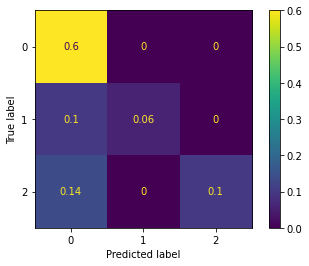

In [212]:
lr_cm = confusion_matrix(Y_test, lr_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,display_labels=[0,1,2])
disp.plot()

We can see that using logistic regression with SMOTE, we have an accuracy of $0.48 + 0.06 + 0.18 = 0.72$.

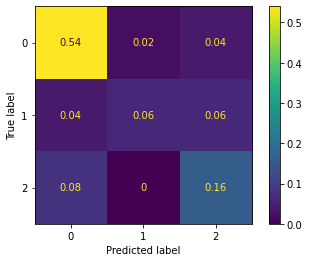

In [213]:
lr_sm_cm = confusion_matrix(Y_test, lr_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_sm_cm,display_labels=[0,1,2])
disp.plot()

We can see that using gradient boosting, we have an accuracy of $0.6 + 0.1 = 0.61$.

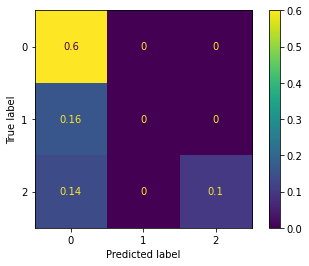

In [214]:
gb_cm = confusion_matrix(Y_test, gb_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm,display_labels=[0,1,2])
disp.plot()

We can see that using gradient boosting with SMOTE, we have an accuracy of $0.48 + 0.00 + 0.12 = 0.60$.

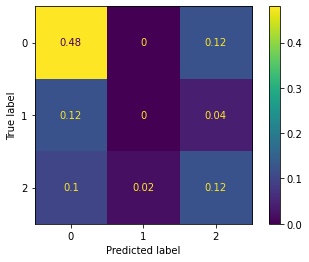

In [215]:
gb_sm_cm = confusion_matrix(Y_test, gb_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_sm_cm,display_labels=[0,1,2])
disp.plot()

# Chosen Model

Logistic Regression with SMOTE was chosen because of its sufficient accuracy and high ROC AUC score. Despite having better accuracy and ROC AUC score when using logistic regression alone, it had the highest rank 2 wrong prediction (0.14), but correctly predicted all the rank 0 cases. 

Taking this into account, it would be safer to predict that a rank 0 is rank 1/2 than predict otherwise.  Hence, the model that has the lesser number of predicted rank 2 as rank 0 was chosen. 

In [216]:
# save predictions in csv file
wrong_pred = pd.DataFrame(X_test, columns =['content'])

wrong_pred.loc[:, 'coordinates'] = df['coordinates']
wrong_pred.loc[:, 'Latitude'] = df['Latitude']
wrong_pred.loc[:, 'Longitude'] = df['Longitude']
wrong_pred.loc[:, 'actual'] = Y_test
wrong_pred.loc[:, 'predicted'] = lr_pred_sm
wrong_pred.loc[:, 'new_score'] = wrong_pred['actual'] + (4* wrong_pred['predicted'])
wrong_pred.head()

wrong_pred.to_csv("wrongpred.csv")

In [217]:
print(wrong_pred['new_score'].value_counts())

0     27
10     8
2      4
9      3
5      3
8      2
1      2
4      1
Name: new_score, dtype: int64


### Extract tweets with rank = 2

In [218]:
df_locs = pd.DataFrame(columns = ['Latitude', 'Longitude'])
df_locs['Latitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Latitude']
df_locs['Longitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Longitude']

df_locs.head()

,Latitude,Longitude
39,10.5470262,124.7434968
80,10.5470262,124.7434968
10,10.2594754,123.7647381
18,10.7922629,124.8438494
4,10.5470262,124.7434968


### Plot the tweets in the geographical heatmap

In [219]:
fol_map = folium.Map(location=[10.847622263721211, 124.88887070186077], zoom_start=8)
markers = df_locs[['Latitude','Longitude']].values
fol_map.add_child(plugins.HeatMap(markers, radius=15))
fol_map